# First attempt of clustering the publications from Science Mag.

#### Steps of BERTopic

![Alt text](./image/StepsOfBerTopic.png)

### Customizing is also possible
![Alt text](./image/Custmizing_SemanticScholar_Steps.png)

In [136]:
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 100)

import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# We have to define, which words we need to add
stop_words = set(ENGLISH_STOP_WORDS)
stop_words.update(['said',"research",'scientist','studies'])
ENGLISH_STOP_WORDS = frozenset(stop_words)

import pickle

# Have check these to out
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, config
config.THREADING_LAYER = 'threadsafe'
from umap import UMAP
from collections import defaultdict
import re
import plotly.graph_objects as go
import plotly.io as pio
from typing import List, Union

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import ast
import plotly.express as px
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances



In [160]:
# Function to load and clean the dataset
def load_clean_dataset(path,years=None):
    # Load the dataset from the specified path
    df = pd.read_csv(path)
    if years: df = df[df['year'].isin(years)]

    # Fill NaN values with empty strings
    df.fillna('', inplace=True)
    
    # List of columns to drop from the DataFrame
    columns_to_drop = [
        'paperId', 'paperId', 's2FieldsOfStudy', 'MAG', 'DOI', 'CorpusId',
        'ArXiv', 'DBLP', 'PubMed', 'PubMedCentral', 'id', 'issn',
        'alternate_issns', 'alternate_urls', 'type', 'publicationTypes', 'url'
    ]
    
    # Drop the specified columns from the DataFrame
    df_c = df.drop(columns=columns_to_drop, axis=1)


    def clean_text(row):
        # Combine 'title' and 'abstract' into a single column
        combined_text = row['title'] + '. ' + row['abstract']

        # Check if 'fieldsOfStudy' exists and is not empty
        if row['fieldsOfStudy']:
            # Parse the string representation of the list into an actual list
            fields_list = ast.literal_eval(row['fieldsOfStudy'])
            # Remove single quotes from each field of study
            cleaned_fields = [field.strip(" '") for field in fields_list]
            # Join the cleaned fields with commas and spaces
            field_of_study_str = ', '.join(cleaned_fields)
            combined_text += '. ' + field_of_study_str

        # Tokenize and remove stopwords
        cleaned_tokens = [word for word in combined_text.split() if word.lower() not in ENGLISH_STOP_WORDS]
        return ' '.join(cleaned_tokens)


    # Apply the clean_text function to each row to create a new 'title_abstract' column
    df_c['title_abstract_studyfield'] = df_c.apply(clean_text, axis=1)
    
    # Shuffle the DataFrame for randomness and reset the index
    df_c = df_c.sample(frac=1).reset_index(drop=True)
    
    print("Length of the dataset: ", len(df_c))
    print("Null in the dataset",df.isnull().sum())
    # Return the cleaned DataFrame
    return df_c

# Function to cluster data using BERTopic
def cluster_data(df,min_topic_size=50,fine_tune_label=False,get_topics=False,get_proba=False):  
    # Extract documents from the 'title_abstract_studyfield' column
    docs = df['title_abstract_studyfield'].tolist()
    
    # Measure the start time for model fitting
    start_time = time.time()
    
    # Create and fit a BERTopic model
    if fine_tune_label:
        representation_model = KeyBERTInspired()
        model = BERTopic(language="english", n_gram_range=(1, 2), min_topic_size=min_topic_size,representation_model=representation_model)
    else:
        model = BERTopic(language="english", n_gram_range=(1, 2), min_topic_size=min_topic_size)
    
    topics, proba = model.fit_transform(docs)
    
    # Calculate the elapsed time for model fitting
    elapsed_time_minutes = (time.time() - start_time) / 60
    
    # Print a message with the elapsed time
    print(f"Model fitting completed in {elapsed_time_minutes:.2f} minutes")
    
    # Return the model
    if get_topics and get_proba:
        return model,topics,proba
    elif get_topics and not get_proba:
        return model,topics
    elif get_proba and not get_topics:
        return model,proba
    return model

# Function to visualize the distribution of study fields
def viz_study_field_distribution(df, vis_length=None):
    # Set the default visualization length to the length of the DataFrame if not provided
    if vis_length is None:
        vis_length = len(df)

    # Calculate the counts of study fields
    source_counts = df['fieldsOfStudy'].value_counts()[:vis_length]

    # Create a figure and a single axis for the bar chart
    fig, ax = plt.subplots(figsize=(15, 6))

    # Plot the study field counts as a bar chart
    source_counts.plot(kind='bar', color='lightblue', edgecolor='black', ax=ax)

    # Set the title and labels for the plot
    ax.set_title('Distribution of Study Fields')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(source_counts)))
    ax.set_xticklabels(source_counts.index, rotation=90, ha="right")

    # Ensure the plot layout is tight
    plt.tight_layout()

    # Display the plot
    plt.show()
    
# Expanding the df to include the topic labels
def add_topic_labels(df,topics,proba,model):
    df['topic_code'] = topics
    df['proba'] = proba
    topic_dict = model.get_topics()
    df['topic_list'] = df['topic_code'].apply(lambda x: topic_dict.get(x, []))
    df['best_topic'] = df['topic_code'].apply(lambda x: topic_dict.get(x, [])[0][0])
    display(df.head())
    return df

def intertopic_distance_map_3d(df,topics,model,umap_embeddings):
    
    # Step 1: Reduce Embeddings to 3D using UMAP
    def reduce_to_3d(embeddings):
        reducer = UMAP(n_components=3)  # You can adjust n_components as needed
        umap_embeddings = reducer.fit_transform(embeddings)
        return umap_embeddings
        
    def calculate_centroids(embeddings, topics):
        unique_topics = np.unique(topics)  # Get unique topic labels
        centroids = np.zeros((len(unique_topics), embeddings.shape[1]))  # Initialize centroids array

        for i, topic in enumerate(unique_topics):
            # Find indices of documents belonging to the current topic
            topic_indices = np.where(topics == topic)[0]
            
            # Extract embeddings for documents in the current topic
            topic_embeddings = embeddings[topic_indices]
            
            # Calculate the centroid by averaging coordinates
            centroid = np.mean(topic_embeddings, axis=0)
            
            # Assign the centroid to the corresponding row in the centroids array
            centroids[i] = centroid

        return centroids

    # Step 2: Calculate Centroids in 3D Space
    def calculate_centroids(umap_embeddings, topics):
        unique_topics = np.unique(topics)
        centroids = np.zeros((len(unique_topics), 3))  # Initialize centroids array

        for i, topic in enumerate(unique_topics):
            # Find indices of documents belonging to the current topic
            topic_indices = np.where(topics == topic)[0]
            
            # Extract 3D coordinates for documents in the current topic
            topic_embeddings = umap_embeddings[topic_indices]
            
            # Calculate the centroid by averaging coordinates
            centroid = np.mean(topic_embeddings, axis=0)
            
            # Assign the centroid to the corresponding row in the centroids array
            centroids[i] = centroid

        return centroids

    # Step 3: Calculate Intertopic Distances
    def calculate_intertopic_distances(centroids):
        distances = pairwise_distances(centroids, metric='euclidean')
        return distances

    def calculate_intertopic_distances(centroids):
        num_topics = len(centroids)
        distances = np.zeros((num_topics, num_topics))

        for i in range(num_topics):
            for j in range(i + 1, num_topics):
                # Calculate Euclidean distance between centroids i and j
                distance = euclidean(centroids[i], centroids[j])
                distances[i, j] = distances[j, i] = distance

        return distances

    # Step 4: Visualization of Intertopic Distances in 3D
    def visualize_intertopic_distances(centroids, topics):
        # Convert your 'topics' list to a NumPy array
        topics_shifted = np.array(topics)

        # Add 1 to all topic labels to include -1
        topics_shifted += 1

        # Now you can calculate topic counts using np.bincount
        topic_counts = np.bincount(topics_shifted)
        
        # Create a scatter plot with points for each topic centroid
        fig = go.Figure()
        print("len topic",len(topic_counts))
        for i, centroid in enumerate(centroids):
            # Calculate the sphere radius based on topic count
            sphere_radius = np.cbrt(topic_counts[i])
            
            # Create a sphere marker for each topic
            fig.add_trace(go.Scatter3d(
                x=[centroid[0]],
                y=[centroid[1]],
                z=[centroid[2]],
                mode='markers',
                marker=dict(size=sphere_radius, color='blue', opacity=0.5),
                text=f'Topic {topics[i]}, Count: {topic_counts[i]}'
            ))
            
        # Customize the color scale if needed
        color_scale = px.colors.sequential.Plasma  # Replace with a desired color scale
        color_variable = topic_counts  # Replace 'petal_length' with the variable you want to use
        fig.update_traces(marker=dict(colorbar=dict(title='Color Bar Title', tickvals=[min(color_variable), max(color_variable)], ticktext=['Min', 'Max']), colorscale=color_scale))

        # Customize the layout if needed
        fig.update_layout(scene=dict(aspectmode='cube'))
        # Customize the layout and axis labels
        fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))
        
        # Show the 3D scatter plot
        fig.show()
        
    # Assuming you have your embeddings, topics, and model
    print("Step 1: Reducing the dimensions of the embeddings ...")
    umap_embeddings = reduce_to_3d(umap_embeddings)  # Step 1
    print("Step 2: Calculating centroids ...")
    centroids = calculate_centroids(umap_embeddings, topics)  # Step 2
    print("Step 3: Calculating intertopic distances ...")
    distances = calculate_intertopic_distances(centroids)  # Step 3
    print("Step 4: Visualizing intertopic distances ...")
    visualize_intertopic_distances(centroids, topics)  # Step 4

# BERTopic on a single year

Length of the dataset:  104
Null in the dataset paperId                     0
title                       0
abstract                    0
year                        0
referenceCount              0
citationCount               0
influentialCitationCount    0
fieldsOfStudy               0
s2FieldsOfStudy             0
publicationTypes            0
publicationDate             0
MAG                         0
DOI                         0
CorpusId                    0
PubMed                      0
ArXiv                       0
DBLP                        0
PubMedCentral               0
id                          0
name                        0
type                        0
issn                        0
alternate_issns             0
url                         0
alternate_urls              0
dtype: int64


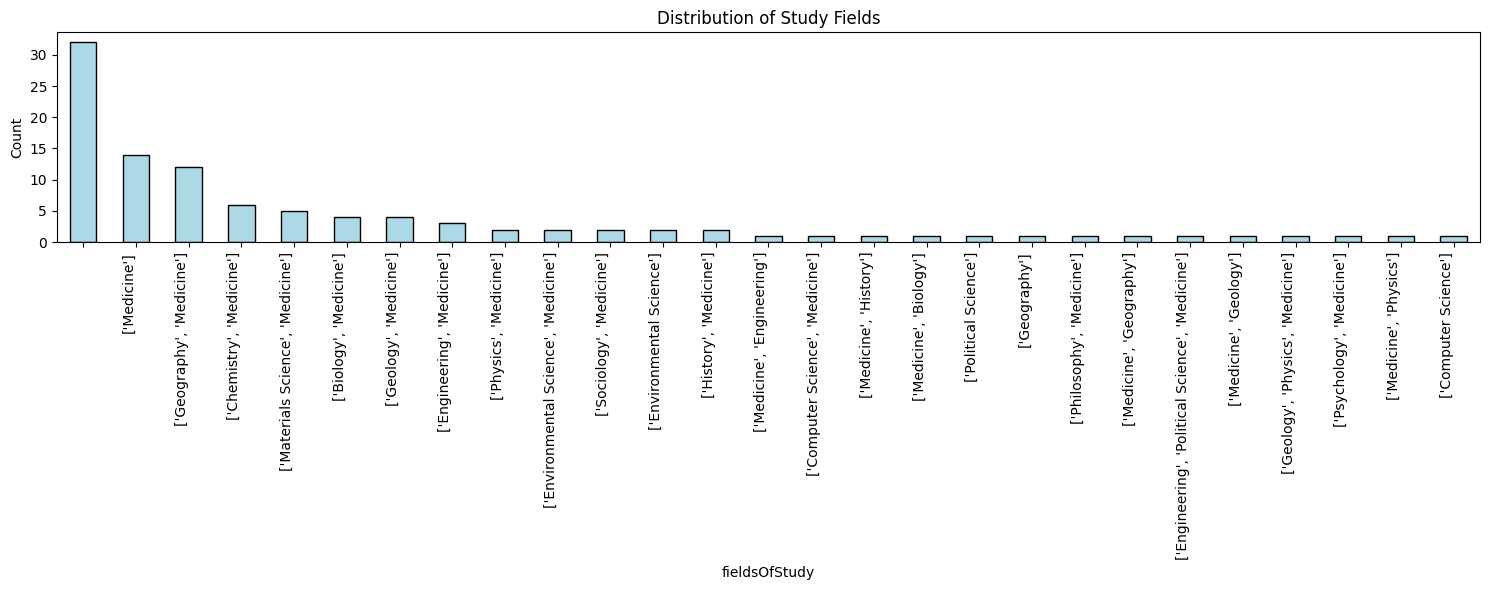

In [23]:
## Filter using the year:
years = [1900]
df = load_clean_dataset("./data/1880-2023_Science_48966.csv",years)
viz_study_field_distribution(df)

In [24]:
# Creating clusters for a single year
single_year_model = cluster_data(df,min_topic_size=5)
# Saving the BERTopic model
single_year_model.save("./models/bertopic_model_"+str(years[0]))
display(single_year_model.get_topic_info())
single_year_model.visualize_topics()

Model fitting completed in 0.07 minutes


,Topic,Count,Name,Representation,Representative_Docs
0,-1,37,-1_erotic_science_solution_work,"[erotic, science, solution, work, families, linguistic, amazon, images, sex, longest]","[Sounding Ocean Air . A. Lawrence Rotch, S.B., A.M. Romance Science Series. London, Society Prom..."
1,0,32,0_books_degeneration_water_conditions,"[books, degeneration, water, conditions, case, survey, larvae, time, study, work]",[Lampreys Captivity. HAVING living lampreys various ages observation biological laboratory Johns...
2,1,14,1_energy_new_effect_chemistry,"[energy, new, effect, chemistry, zeeman, york, electron, magnetic, levels, field]","[Calculations Analytical Chemistry . E. H. Miller, Ph.D., Instructor Analytical Chemistry Assayi..."
3,2,8,2_fowl_sterna_domesticated_deformed,"[fowl, sterna, domesticated, deformed, fox, exotic, ulke, coleoptera, blue, cruise]","[BLUE FOX TRAPPING PRIBILOF ISLANDS.. . [, ', M, a, t, e, r, i, a, l, s, , S, c, i, e, n, c, e, ..."
4,3,7,3_botanical_torrey_club_notes,"[botanical, torrey, club, notes, botany, 1900, twentieth, textbooks, structures, second]","[Torrey Botanical Club, October 9, 1900. . [, ', G, e, o, g, r, a, p, h, y, ', ], Torrey Botanic..."
5,4,6,4_society_biological_washington_medical,"[society, biological, washington, medical, activities, health, services, letter, cowie, will]","[Biological Society Washington., DISCLAIMER. Finally, benefit aforementioned correspondents, fee..."


# BERTopic on the whole Science data set

Length of the dataset:  48966
Null in the dataset paperId                     0
title                       0
abstract                    0
year                        0
referenceCount              0
citationCount               0
influentialCitationCount    0
fieldsOfStudy               0
s2FieldsOfStudy             0
publicationTypes            0
publicationDate             0
MAG                         0
DOI                         0
CorpusId                    0
PubMed                      0
ArXiv                       0
DBLP                        0
PubMedCentral               0
id                          0
name                        0
type                        0
issn                        0
alternate_issns             0
url                         0
alternate_urls              0
dtype: int64


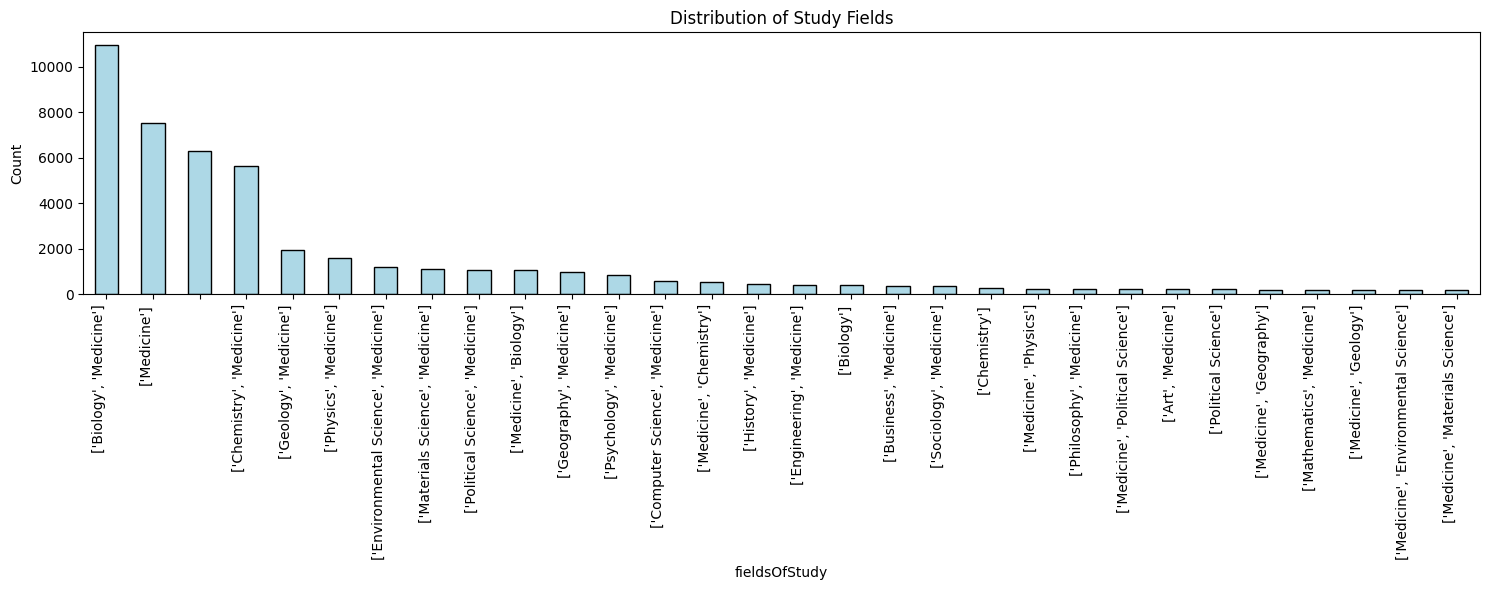

In [99]:
# Load the whole dataset
df = load_clean_dataset("./data/1880-2023_Science_48966.csv")
viz_study_field_distribution(df,30)

In [85]:
# Creating clusters for the whole data set
model,topics,proba = cluster_data(df,min_topic_size=50,fine_tune_label=True,get_topics=True,get_proba=True)
# Saving the BERTopic model
model.save("./models/bertopic_model_whole_data_set.brt")
df = add_topic_labels(df,topics,proba,model)
display(model.get_topic_info())
model.visualize_topics()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/pclinux/spiced/data_science/capstone_project/convergence_oracle/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



,Topic,Count,Name,Representation,Representative_Docs
0,-1,25775,-1_cells_cell_genes_biological,"[cells, cell, genes, biological, biology, gene, biology medicine, rna, signaling, cellular]",[Control signaling-mediated clearance apoptotic cells tumor suppressor p53. Tumor suppressor p53...
1,0,710,0_organic chemistry_physical chemistry_chemistry_chemical analysis,"[organic chemistry, physical chemistry, chemistry, chemical analysis, compounds, chemical, inorg...","[Chemical Processes: Inorganic Reaction Mechanisms . John O. Edwards, Ed. Interscience (Wiley), ..."
2,1,660,1_honey bees_bees_honey bee_bee,"[honey bees, bees, honey bee, bee, honeybees, pollination, insecticides, insects, insect, entomo...",[Honey Bees Humans: Shared Innovation. discussion sequencing genome honey bee (“Honey bee genome...
3,2,600,2_marine ecosystems_fisheries_coral reefs_fishery,"[marine ecosystems, fisheries, coral reefs, fishery, coral reef, ecological, reefs, reef, ecosys...",[Socioeconomic impacts marine heatwaves: Global issues opportunities. Description impacts marine...
4,3,591,3_biodiversity_biodiversity conservation_biodiversity loss_ecological,"[biodiversity, biodiversity conservation, biodiversity loss, ecological, ecosystem, ecology, eco...",[biodiversity Anthropocene. Fire's growing impacts ecosystems played prominent role evolution bi...
5,4,495,4_medicine geology_geology medicine_medicine geological_geology,"[medicine geology, geology medicine, medicine geological, geology, geology mineralogy, us geolog...","[PROGRESS GEOLOGICAL SURVEY CALIFORNIA.. . Geology, Medicine, WORK U. S. GEOLOGICAL SURVEY, 1899..."
6,5,465,5_antarctic ice_greenland ice_global warming_climate variability,"[antarctic ice, greenland ice, global warming, climate variability, climate change, glacial, gla...",[Reconciled Estimate Ice-Sheet Mass Balance. Warming Melting Mass loss ice sheets Greenland Anta...
7,6,442,6_medicine political_political science_medicine science_medicine politics,"[medicine political, political science, medicine science, medicine politics, science political, ...","[BRITISH ASSOCIATION ADVANCEMENT SCIENCE.. . Political Science, Medicine, AMERICAN ASSOCIATION A..."
8,7,439,7_grad_academia_teaching_mentor,"[grad, academia, teaching, mentor, academic, graduate, science education, undergraduate, student...","[Undergrads charge.. entered main conference room chemistry building, feeling nervous. arrive, h..."
9,8,397,8_lunar samples_meteorites_lunar surface_meteorite,"[lunar samples, meteorites, lunar surface, meteorite, craters, carbonaceous chondrite, minerals,...",[Soluble organic molecules samples carbonaceous asteroid (162173) Ryugu. Hayabusa2 spacecraft co...


In [103]:
my_embeddings = model._extract_embeddings(df['title_abstract_studyfield'].to_list(), method="document")
my_embeddings.shape

(48966, 384)

In [161]:
intertopic_distance_map_3d(df,topics,model,my_embeddings)


Step 1: Reducing the dimensions of the embeddings ...
Step 2: Calculating centroids ...
Step 3: Calculating intertopic distances ...
Step 4: Visualizing intertopic distances ...
len topic 133


In [125]:
my_embeddings.shape

(48966, 384)

In [147]:
np.bincount(topics)

ValueError: 'list' argument must have no negative elements

In [127]:
np.unique(topics)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131])

In [100]:
df.head()

,title,abstract,year,referenceCount,citationCount,influentialCitationCount,fieldsOfStudy,publicationDate,name,title_abstract_studyfield
0,"Cells in Culture:\n Biology of Fibroblast\n . Proceedings of a symposium, Turku, Finland, Aug. 1...",,1975,0,0,0,,1975-01-31,Science,"Cells Culture: Biology Fibroblast . Proceedings symposium, Turku, Finland, Aug. 1972. E. Kulonen..."
1,"Green revolution (I): a just technology, often unjust in use.",,1974,0,29,1,"['Political Science', 'Medicine']",1974-12-20,Science,"Green revolution (I): just technology, unjust use.. . Political Science, Medicine"
2,Protein interaction mapping in C. elegans using proteins involved in vulval development.,Protein interaction mapping using large-scale two-hybrid analysis has been proposed as a way to ...,2000,50,801,23,"['Biology', 'Medicine']",2000-01-07,Science,Protein interaction mapping C. elegans using proteins involved vulval development.. Protein inte...
3,Structure of collagen in cartilage of intervertebral disk.,Small-angle x-ray and neutron diffraction patterns have been obtained from the annulus fibrosus ...,1978,7,21,0,"['Materials Science', 'Medicine']",1978-02-03,Science,Structure collagen cartilage intervertebral disk.. Small-angle x-ray neutron diffraction pattern...
4,A Point of View,Korinth et al found that their success rate was significantly higher after anterior microdiscect...,1968,0,0,0,,1968-07-19,Science,Point View. Korinth et al success rate significantly higher anterior microdiscectomy polymethyl ...


In [101]:
df['title_abstract_studyfield'][2]

,title,abstract,year,referenceCount,citationCount,influentialCitationCount,fieldsOfStudy,publicationDate,name,title_abstract_studyfield,topic_code,proba,topic_list,best_topic
0,"Cells in Culture:\n Biology of Fibroblast\n . Proceedings of a symposium, Turku, Finland, Aug. 1...",,1975,0,0,0,,1975-01-31,Science,"Cells Culture: Biology Fibroblast . Proceedings symposium, Turku, Finland, Aug. 1972. E. Kulonen...",2,0.952229,"[(marine ecosystems, 0.63954794), (fisheries, 0.5062736), (coral reefs, 0.47839198), (fishery, 0...",marine ecosystems
1,"Green revolution (I): a just technology, often unjust in use.",,1974,0,29,1,"['Political Science', 'Medicine']",1974-12-20,Science,"Green revolution (I): just technology, unjust use.. . Political Science, Medicine",8,0.486591,"[(lunar samples, 0.5543606), (meteorites, 0.4395031), (lunar surface, 0.42918652), (meteorite, 0...",lunar samples
2,Protein interaction mapping in C. elegans using proteins involved in vulval development.,Protein interaction mapping using large-scale two-hybrid analysis has been proposed as a way to ...,2000,50,801,23,"['Biology', 'Medicine']",2000-01-07,Science,Protein interaction mapping C. elegans using proteins involved vulval development.. Protein inte...,-1,0.000000,"[(cells, 0.39353842), (cell, 0.36536178), (genes, 0.3637211), (biological, 0.35699922), (biology...",cells
3,Structure of collagen in cartilage of intervertebral disk.,Small-angle x-ray and neutron diffraction patterns have been obtained from the annulus fibrosus ...,1978,7,21,0,"['Materials Science', 'Medicine']",1978-02-03,Science,Structure collagen cartilage intervertebral disk.. Small-angle x-ray neutron diffraction pattern...,-1,0.000000,"[(cells, 0.39353842), (cell, 0.36536178), (genes, 0.3637211), (biological, 0.35699922), (biology...",cells
4,A Point of View,Korinth et al found that their success rate was significantly higher after anterior microdiscect...,1968,0,0,0,,1968-07-19,Science,Point View. Korinth et al success rate significantly higher anterior microdiscectomy polymethyl ...,26,1.000000,"[(coronavirus sarscov2, 0.61127317), (syndrome coronavirus, 0.55161893), (coronavirus disease, 0...",coronavirus sarscov2


'Protein interaction mapping C. elegans using proteins involved vulval development.. Protein interaction mapping using large-scale two-hybrid analysis proposed way functionally annotate large numbers uncharacterized proteins predicted complete genome sequences. approach examined Caenorhabditis elegans, starting 27 proteins involved vulval development. resulting map reveals known new potential interactions provides functional annotation approximately 100 uncharacterized gene products. protein interaction mapping project feasible C. elegans genome-wide scale contribute understanding molecular mechanisms organism human diseases.. Biology, Medicine'

In [92]:
# Assuming you have already fitted a BERTopic model
topic_info_df = model.get_topic_info()

# Display the contents of the DataFrame
display(topic_info_df)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,25775,-1_cells_cell_genes_biological,"[cells, cell, genes, biological, biology, gene, biology medicine, rna, signaling, cellular]",[Control signaling-mediated clearance apoptotic cells tumor suppressor p53. Tumor suppressor p53...
1,0,710,0_organic chemistry_physical chemistry_chemistry_chemical analysis,"[organic chemistry, physical chemistry, chemistry, chemical analysis, compounds, chemical, inorg...","[Chemical Processes: Inorganic Reaction Mechanisms . John O. Edwards, Ed. Interscience (Wiley), ..."
2,1,660,1_honey bees_bees_honey bee_bee,"[honey bees, bees, honey bee, bee, honeybees, pollination, insecticides, insects, insect, entomo...",[Honey Bees Humans: Shared Innovation. discussion sequencing genome honey bee (“Honey bee genome...
3,2,600,2_marine ecosystems_fisheries_coral reefs_fishery,"[marine ecosystems, fisheries, coral reefs, fishery, coral reef, ecological, reefs, reef, ecosys...",[Socioeconomic impacts marine heatwaves: Global issues opportunities. Description impacts marine...
4,3,591,3_biodiversity_biodiversity conservation_biodiversity loss_ecological,"[biodiversity, biodiversity conservation, biodiversity loss, ecological, ecosystem, ecology, eco...",[biodiversity Anthropocene. Fire's growing impacts ecosystems played prominent role evolution bi...
5,4,495,4_medicine geology_geology medicine_medicine geological_geology,"[medicine geology, geology medicine, medicine geological, geology, geology mineralogy, us geolog...","[PROGRESS GEOLOGICAL SURVEY CALIFORNIA.. . Geology, Medicine, WORK U. S. GEOLOGICAL SURVEY, 1899..."
6,5,465,5_antarctic ice_greenland ice_global warming_climate variability,"[antarctic ice, greenland ice, global warming, climate variability, climate change, glacial, gla...",[Reconciled Estimate Ice-Sheet Mass Balance. Warming Melting Mass loss ice sheets Greenland Anta...
7,6,442,6_medicine political_political science_medicine science_medicine politics,"[medicine political, political science, medicine science, medicine politics, science political, ...","[BRITISH ASSOCIATION ADVANCEMENT SCIENCE.. . Political Science, Medicine, AMERICAN ASSOCIATION A..."
8,7,439,7_grad_academia_teaching_mentor,"[grad, academia, teaching, mentor, academic, graduate, science education, undergraduate, student...","[Undergrads charge.. entered main conference room chemistry building, feeling nervous. arrive, h..."
9,8,397,8_lunar samples_meteorites_lunar surface_meteorite,"[lunar samples, meteorites, lunar surface, meteorite, craters, carbonaceous chondrite, minerals,...",[Soluble organic molecules samples carbonaceous asteroid (162173) Ryugu. Hayabusa2 spacecraft co...


In [128]:
topic_dict = model.get_topics()
display(len(topic_dict))

133